# Task 1 : Set up colab gpu runtime environment

In [41]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-71elecyr
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-71elecyr
  Resolved https://github.com/albumentations-team/albumentations to commit 6f7bc1da9fd37f8471bdeb6dd6b328dd6033a098
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

# U-Net Architecture

![U-NET Architecture](https://camo.githubusercontent.com/52aa73297ce589a19efb0458a6055de2d4563277c933803a740aeab165071365/68747470733a2f2f692e696d6775722e636f6d2f6a6544567071462e706e67)

# Download Subset Dataset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 38.94 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Importing the required libraries

In [3]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper
# from PIL import Image

# Task : 2 Setup Configurations

In [47]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'
EPOCHS = 31
LR = 0.004
BATCH_SIZE = 16
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [13]:
index = 31

row = df.iloc[index]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

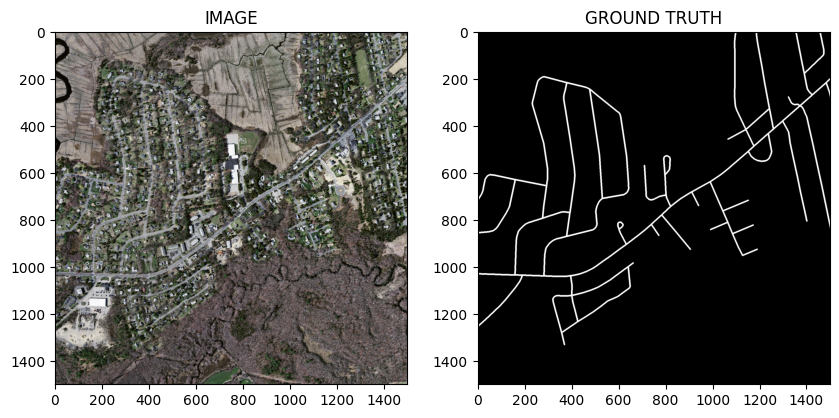

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [15]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

In [16]:
len(valid_df)

40

In [18]:
len(train_df)

159

# Task 3: Augmentations

In [19]:
import albumentations as A

In [20]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4: Creating Custom Dataset

In [21]:
from torch.utils.data import Dataset

In [26]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # (H, W, C)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (H, W)
    mask = np.expand_dims(mask, axis=-1) # (H, W, C)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image'] # (H, W, C)
      mask = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32) # (C, H, W)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32) # (C, H, W)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [27]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [28]:
print(f'Size of trainset : {len(trainset)}')
print(f'Size of validset : {len(validset)}')

Size of trainset : 159
Size of validset : 40


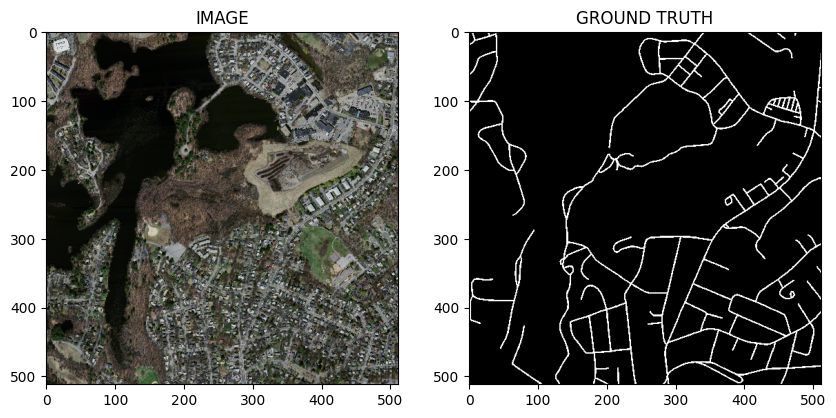

In [34]:
index = 37

image, mask = trainset[index]

helper.show_image(image, mask)

# Task 5: Loading the Dataset in batches

In [35]:
from torch.utils.data import DataLoader

In [36]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [37]:
print(f'Total number of batches in trainloader: {len(trainloader)}')
print(f'Total number of batches in validloader: {len(validloader)}')

Total number of batches in trainloader: 10
Total number of batches in validloader: 3


In [39]:
for images, masks in trainloader:
  print(f'One batch image shape : {images.shape}')
  print(f'One batch mask shape : {masks.shape}')
  break;

One batch image shape : torch.Size([16, 3, 512, 512])
One batch mask shape : torch.Size([16, 1, 512, 512])


# Task 6: Creating Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [44]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [45]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks=None):
    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits

In [48]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 175MB/s]


SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

# Task 7: Creating Train & Validation Functions

In [55]:
def train_fn(dataloader, model, optimizer):
  model.train() # Turn ON dropout, batchnorm, etc...
  total_loss = 0.0

  for images, masks in tqdm(dataloader):
    images =images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()
    logits, loss = model(images ,masks)
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()

  return total_loss / len(dataloader)

In [51]:
def eval_fn(dataloader, model):
  model.eval() # Turn OFF dropout, batchnorm, etc...
  total_loss = 0.0

  with torch.no_grad():

    for images, masks in tqdm(dataloader):
      images =images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images ,masks)

      total_loss+=loss.item()

  return total_loss / len(dataloader)

# Task 8 : Model Training

In [52]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [57]:
best_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), 'best-seg-model.pt')
    print('SAVED MODEL')
    best_loss = valid_loss

  print(f'Epoch: {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}')

100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


SAVED MODEL
Epoch: 1 Train Loss : 0.9608639240264892 Valid Loss : 0.9968544046084086


100%|██████████| 3/3 [00:03<00:00,  1.29s/it]


SAVED MODEL
Epoch: 2 Train Loss : 0.7913423359394074 Valid Loss : 0.8742717901865641


100%|██████████| 3/3 [00:03<00:00,  1.29s/it]


SAVED MODEL
Epoch: 3 Train Loss : 0.7288897693157196 Valid Loss : 0.7838006416956583


100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


SAVED MODEL
Epoch: 4 Train Loss : 0.693672490119934 Valid Loss : 0.7694658438364664


100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


SAVED MODEL
Epoch: 5 Train Loss : 0.6820662319660187 Valid Loss : 0.7616756757100424


100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


SAVED MODEL
Epoch: 6 Train Loss : 0.6600542545318604 Valid Loss : 0.7172088225682577


100%|██████████| 3/3 [00:03<00:00,  1.29s/it]


Epoch: 7 Train Loss : 0.6493650257587433 Valid Loss : 0.7172327836354574


100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


SAVED MODEL
Epoch: 8 Train Loss : 0.6322706580162049 Valid Loss : 0.6766168475151062


100%|██████████| 3/3 [00:04<00:00,  1.35s/it]


SAVED MODEL
Epoch: 9 Train Loss : 0.6276073276996612 Valid Loss : 0.672025740146637


100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


SAVED MODEL
Epoch: 10 Train Loss : 0.6261345565319061 Valid Loss : 0.6565481424331665


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Epoch: 11 Train Loss : 0.6049869060516357 Valid Loss : 0.6806444128354391


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


Epoch: 12 Train Loss : 0.6131873011589051 Valid Loss : 0.67292453845342


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 13 Train Loss : 0.610312533378601 Valid Loss : 0.7280955712000529


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Epoch: 14 Train Loss : 0.5972283065319062 Valid Loss : 0.6740129590034485


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch: 15 Train Loss : 0.5934931814670563 Valid Loss : 0.6757993698120117


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 16 Train Loss : 0.5946123123168945 Valid Loss : 0.6950079003969828


100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


SAVED MODEL
Epoch: 17 Train Loss : 0.5812504351139068 Valid Loss : 0.6358822186787924


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


Epoch: 18 Train Loss : 0.576501989364624 Valid Loss : 0.6458462079366049


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


SAVED MODEL
Epoch: 19 Train Loss : 0.58663991689682 Valid Loss : 0.6243963241577148


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 20 Train Loss : 0.5720001995563507 Valid Loss : 0.6322782437006632


100%|██████████| 3/3 [00:07<00:00,  2.49s/it]


Epoch: 21 Train Loss : 0.5830339908599853 Valid Loss : 0.6570391058921814


100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


Epoch: 22 Train Loss : 0.5822280406951904 Valid Loss : 0.6591443419456482


100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


Epoch: 23 Train Loss : 0.5873333215713501 Valid Loss : 0.6307267745335897


100%|██████████| 3/3 [00:06<00:00,  2.19s/it]


Epoch: 24 Train Loss : 0.5805651426315308 Valid Loss : 0.6761118372281393


100%|██████████| 3/3 [00:05<00:00,  1.95s/it]


Epoch: 25 Train Loss : 0.5687864482402801 Valid Loss : 0.6867599487304688


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 26 Train Loss : 0.5615006268024445 Valid Loss : 0.6278026103973389


100%|██████████| 3/3 [00:03<00:00,  1.29s/it]


Epoch: 27 Train Loss : 0.5588873416185379 Valid Loss : 0.6248996257781982


100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


Epoch: 28 Train Loss : 0.5847673833370208 Valid Loss : 0.6530688802401224


100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


Epoch: 29 Train Loss : 0.5959735870361328 Valid Loss : 0.7814622124036154


100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


Epoch: 30 Train Loss : 0.5878611624240875 Valid Loss : 0.7078794240951538


100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

Epoch: 31 Train Loss : 0.5599473595619202 Valid Loss : 0.6539893547693888


# Task 9 : Inference

In [66]:
index = 2

model.load_state_dict(torch.load('/content/best-seg-model.pt'))
image, mask = validset[index]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) ==> (B, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

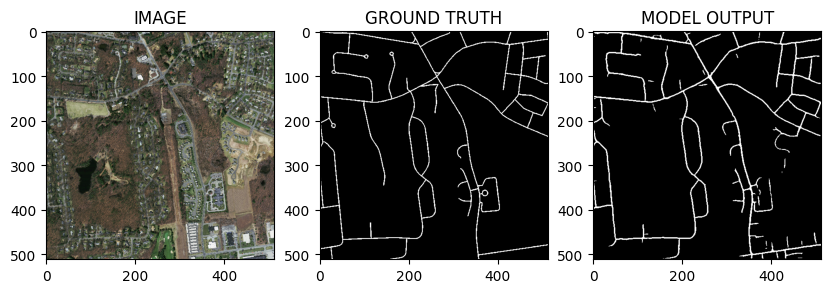

In [67]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))